# Light curve - Flare

## Introduction

In this notebook, I try to do a simultaneous fitting of the PKS 2155-304 flares from the Chandra night.

The first part of the notebook is the gammapy flare lightcurve. The datasets thus obtained are used to do the modelling and fitting in the later section (so jump directly to the Fitting section for the new results)

In [3]:
%matplotlib inline
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion
from astropy.coordinates import Angle

import logging

log = logging.getLogger(__name__)

from gammapy.data import DataStore
from gammapy.datasets import SpectrumDataset
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator, LightCurve
from gammapy.makers import (
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
)

In [4]:
import gammapy
gammapy.__version__

'0.16.dev734+g277ede6d1'

## Select the data

We first set the datastore.

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

Now we select observations within 2 degrees of PKS 2155-304. 

In [6]:
target_position = SkyCoord(
    329.71693826 * u.deg, -30.2255890 * u.deg, frame="icrs"
)
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_position.ra,
    lat=target_position.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 21


## Define time intervals
We create the list of time intervals. Each time interval is an `~astropy.time.Time` object, containing a start and stop time.

In [7]:
t0 = Time("2006-07-29T20:30")
duration = 10 * u.min
n_time_bins = 35
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [
    Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])
]
print(time_intervals[0].mjd)

[53945.85416667 53945.86111111]


## Filter the observations list in time intervals

Here we apply the list of time intervals to the observations with `~gammapy.data.Observations.select_time()`.

This will return a new list of Observations filtered by time_intervals. For each time interval, a new observation is created that convers the intersection of the GTIs and time interval. 

In [8]:
short_observations = observations.select_time(time_intervals)
# check that observations have been filtered
print(
    f"Number of observations after time filtering: {len(short_observations)}\n"
)
print(short_observations[1].gti)

Number of observations after time filtering: 44

GTI info:
- Number of GTIs: 1
- Duration: 600.0 s
- Start: 53945.861865555555 MET
- Start: 2006-07-29T20:41:05.184 (time standard: TT)
- Stop: 53945.86881 MET
- Stop: 2006-07-29T20:51:05.184 (time standard: TT)



As we can see, we have now observations of duration equal to the chosen time step.

Now data reduction and light curve extraction can proceed exactly as before.

## Building 1D datasets from the new observations

Here we will perform the data reduction in 1D with reflected regions.

*Beware, with small time intervals the background normalization with OFF regions might become problematic.*

### Defining the geometry

We define the energy axes. As usual, the true energy axis has to cover a wider range to ensure a good coverage of the measured energy range chosen. 

We need to define the ON extraction region. Its size follows typical spectral extraction regions for HESS analyses.

In [9]:
# Target definition
e_reco = MapAxis.from_energy_bounds(0.4, 20, 10, "TeV").edges
e_true = MapAxis.from_energy_bounds(0.1, 40, 20, "TeV").edges

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

### Creation of the data reduction makers

We now create the dataset and background makers for the selected geometry.

In [10]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "aeff", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

### Creation of the datasets

Now we perform the actual data reduction in the time_intervals.

In [11]:
%%time
datasets = []

dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

CPU times: user 14.1 s, sys: 432 ms, total: 14.5 s
Wall time: 14.5 s


## Define the Model

The actual flux will depend on the spectral shape assumed. For simplicity, we use the power law spectral model of index 3.4 used in the [reference paper](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract).

Here we use only a spectral model in the `~gammapy.modeling.models.SkyModel` object.

In [12]:
spectral_model = PowerLawSpectralModel(
    index=3.4,
    amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(
    spatial_model=None, spectral_model=spectral_model, name="pks2155"
)

### Assign to model to all datasets

We assign each dataset its spectral model

In [13]:
for dataset in datasets:
    dataset.models = sky_model

## Extract the light curve

We first create the `~gammapy.time.LightCurveEstimator` for the list of datasets we just produced. We give the estimator the name of the source component to be fitted.

In [14]:
lc_maker_1d = LightCurveEstimator(datasets, source="pks2155")

We can now perform the light curve extraction itself. To compare with the [reference paper](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract), we select the 0.7-20 TeV range.

In [15]:
%%time
lc_1d = lc_maker_1d.run(e_ref=1 * u.TeV, e_min=0.7 * u.TeV, e_max=20.0 * u.TeV)

CPU times: user 5.08 s, sys: 21.1 ms, total: 5.1 s
Wall time: 5.1 s


Finally we plot the result for the 1D lightcurve:

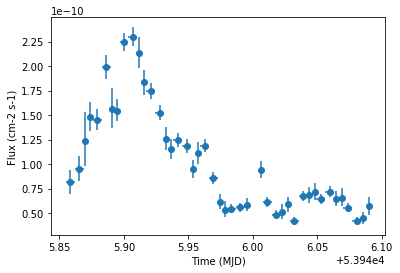

In [16]:
lc_1d.plot(marker="o")

# Fitting 

This starts the new part of the notebook. 
We try to fit the flare profiles.

For sake of simplicity, we only model the first and the last features - they look well behaved! This basically explains how to assign different models to different datasets to do the fitting. With sufficient motivation, the other points can be modelled as well

We first use scipy to model the flux points to see if a joint fit might be reasonable

## Modeling the flux points with 2 Gaussians - a standard thing 

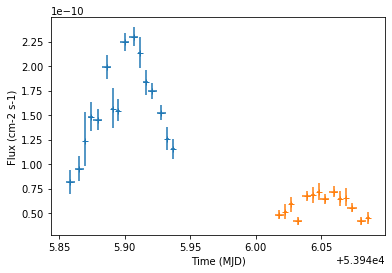

In [18]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Extract the two features to be modeled
lc_part1 = LightCurve(lc_1d.table[0:16])
lc_part1.plot()

lc_part2 = LightCurve(lc_1d.table[-15:-1])
lc_part2.plot()


In [19]:
x = np.append(lc_part1._get_times_and_errors()[0], lc_part2._get_times_and_errors()[0])
y = np.append(lc_part1.table["flux"].quantity.to_value('1/ (cm2 s)'), lc_part2.table["flux"].quantity.to_value('1/ (cm2 s)'))
yerr = np.append(lc_part1.table["flux_err"].quantity.to_value('1/ (cm2 s)'), lc_part2.table["flux_err"].quantity.to_value('1/ (cm2 s)'))

In [20]:
def gauss(x, A, tmean, tsig):
    return A*np.exp(-(x-tmean)**2/(2.0*tsig**2))

In [21]:
def lc(x, A1, m1, s1, A2, m2, s2):
    f1 = gauss(x, A1, m1, s1)
    f2 = gauss(x, A2, m2, s2)
    return (f1+f2)

In [22]:
popt, pcov = curve_fit(lc, x, y, sigma=yerr, p0=[1e-10, 53945.9, 0.01, 1e-11, 53946.05, 0.03])
print(popt)

[2.10034254e-10 5.39459032e+04 3.06881355e-02 6.71324346e-11
 5.39460517e+04 3.44491246e-02]


In [23]:
x1 = np.linspace(x[0] ,x[-1] ,100)
y1 = lc(x1, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

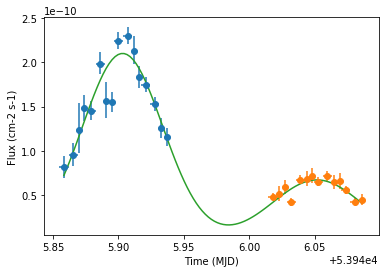

In [24]:
ax = lc_part1.plot(marker="o")
ax = lc_part2.plot(marker="o")
ax.plot(x1,y1)

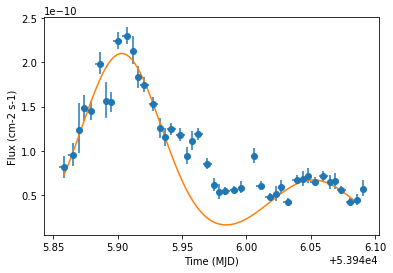

In [25]:
ax = lc_1d.plot(marker="o")
ax.plot(x1,y1)

Since a sum of 2 Gaussians well models the observed flux points, I try to fit a temporal model to the datasets.

## Simultaneous fitting of datasets - fit temporal model

In [26]:
from gammapy.modeling.models import GaussianTemporalModel, ExpDecayTemporalModel, ConstantTemporalModel
from gammapy.modeling import Fit


In [27]:
temporal1 = GaussianTemporalModel(t_ref = 53945.9, sigma=10.0*u.min)
temporal1.parameters["t_ref"].frozen = False
temporal1.parameters["t_ref"].max = 53946.95
temporal1.parameters["t_ref"].min = 53945.85

temporal2 = GaussianTemporalModel(t_ref = 53946.07, sigma=3.0*u.min)
temporal2.parameters["t_ref"].frozen = False
temporal2.parameters["t_ref"].max = 53946.10
temporal2.parameters["t_ref"].min = 53946.01


spectral_model1 = PowerLawSpectralModel(
    index=3.4,
    amplitude=1e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model1.parameters['index'].frozen = True

spectral_model2 = PowerLawSpectralModel(
    index=3.4,
    amplitude=1e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model2.parameters['index'].frozen = True
model1 = SkyModel(spectral_model=spectral_model1, temporal_model=temporal1, name="flare1")
model2 = SkyModel(spectral_model=spectral_model2, temporal_model=temporal2, name="flare2")

In [28]:
#Attaching the models on the datasets to be fitted
datasets_fit = []
for ds in datasets[:16]:
    ds.models = model1
    datasets_fit.append(ds)
    
for ds in datasets[-15:-1]:
    ds.models = model2
    datasets_fit.append(ds)


In [29]:
%%time
fit = Fit(datasets_fit)
result = fit.optimize()

CPU times: user 1min 19s, sys: 194 ms, total: 1min 19s
Wall time: 1min 19s


In [30]:
result.success

True

In [31]:
result.total_stat

350.2685157538987

In [32]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
t_ref,5.395e+04,nan,,5.395e+04,5.395e+04,False
sigma,3.021e-02,nan,d,nan,nan,False
index,3.400e+00,nan,,nan,nan,True
amplitude,2.177e-10,nan,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,nan,TeV,nan,nan,True
t_ref,5.395e+04,nan,,5.395e+04,5.395e+04,False
sigma,3.515e-02,nan,d,nan,nan,False
index,3.400e+00,nan,,nan,nan,True
amplitude,6.901e-11,nan,cm-2 s-1 TeV-1,nan,nan,False


In [33]:
model1.parameters['t_ref']

Parameter(name='t_ref', value=53945.90291769685, factor=5.394590291769685, scale=10000.0, unit=Unit(dimensionless), min=53945.85, max=53946.95, frozen=False, id=0x123595978)

In [34]:
model2.parameters['t_ref']

Parameter(name='t_ref', value=53946.051272073506, factor=5.394605127207351, scale=10000.0, unit=Unit(dimensionless), min=53946.01, max=53946.1, frozen=False, id=0x123595c88)

In [35]:
cnts = []
npreds = []
times = []
lvtm = []
for ds in datasets_fit:
    cnts.append(ds.counts.data.sum())
    npreds.append(ds.npred().data.sum())
    lvtm.append(ds.livetime.value)
    times.append((ds.gti.time_start + ds.gti.time_delta/2.0).mjd)

In [36]:
residuals = (np.array(cnts) - np.array(npreds))/np.array(npreds)

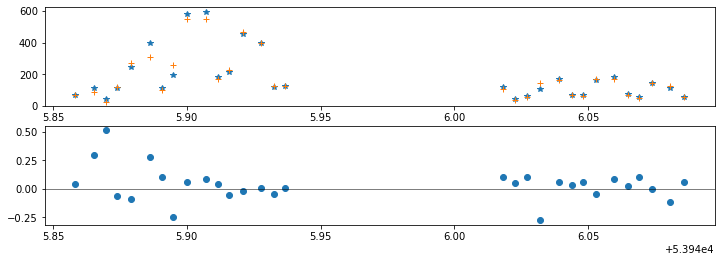

In [37]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(times, cnts, "*")
ax1.plot(times, npreds, "+")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(times, residuals, "o")
ax2.axhline(0, color="black", lw=0.5)

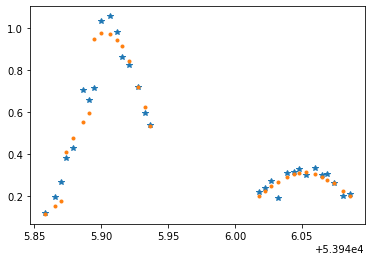

In [38]:
plt.plot(times, np.divide(cnts, lvtm), "*")
plt.plot(times, np.divide(npreds, lvtm), ".")

The fit works well.
The power of this method is we can try to do fun things with it.
Eg: Try to see if there are spectral changes between the flares

In [39]:
# Free the spectral parameter
model1.spectral_model.parameters['index'].frozen = False
model2.spectral_model.parameters['index'].frozen = False

In [40]:
%%time
fit = Fit(datasets_fit)
result = fit.optimize()

CPU times: user 28.8 s, sys: 76.5 ms, total: 28.9 s
Wall time: 28.9 s


In [41]:
result.success

True

In [42]:
result.total_stat

296.82118702692577

In [43]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
t_ref,5.395e+04,nan,,5.395e+04,5.395e+04,False
sigma,3.151e-02,nan,d,nan,nan,False
index,3.572e+00,nan,,nan,nan,False
amplitude,2.007e-10,nan,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,nan,TeV,nan,nan,True
t_ref,5.395e+04,nan,,5.395e+04,5.395e+04,False
sigma,3.516e-02,nan,d,nan,nan,False
index,3.763e+00,nan,,nan,nan,False
amplitude,5.635e-11,nan,cm-2 s-1 TeV-1,nan,nan,False


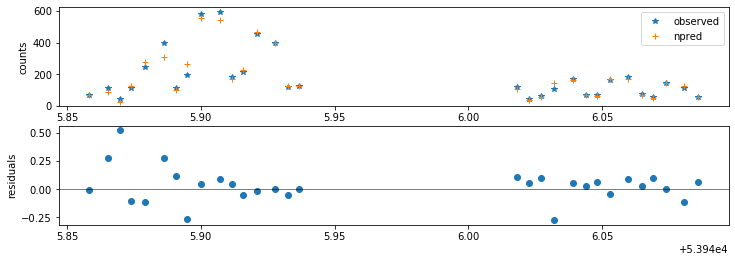

In [44]:
cnts = []
npreds = []
times = []
lvtm = []
for ds in datasets_fit:
    cnts.append(ds.counts.data.sum())
    npreds.append(ds.npred().data.sum())
    lvtm.append(ds.livetime.value)
    times.append((ds.gti.time_start + ds.gti.time_delta/2.0).mjd)
residuals = (np.array(cnts) - np.array(npreds))/np.array(npreds)
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(times, cnts, "*", label="observed")
ax1.plot(times, npreds, "+",  label="npred")
ax1.set_ylabel("counts")
ax1.legend()


ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(times, residuals, "o")
ax2.axhline(0, color="black", lw=0.5)
ax2.set_ylabel("residuals")
ax1.set_xlabel("time");

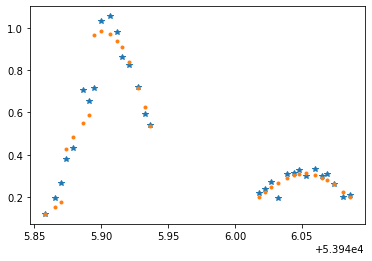

In [45]:
plt.plot(times, np.divide(cnts, lvtm), "*")
plt.plot(times, np.divide(npreds, lvtm), ".")